In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [9]:
paths = ["BSRN-PAY.nc", "BSRN-BAR.nc", "BSRN-BOU.nc"]
times_begin = [
    np.datetime64("1993-01-01"),
    np.datetime64("1999-01-01"),
    np.datetime64("1999-01-01")
]
times_end = [
    np.datetime64("2023-01-01"),
    np.datetime64("2023-01-01"),
    np.datetime64("2016-01-01")
]

In [142]:
PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

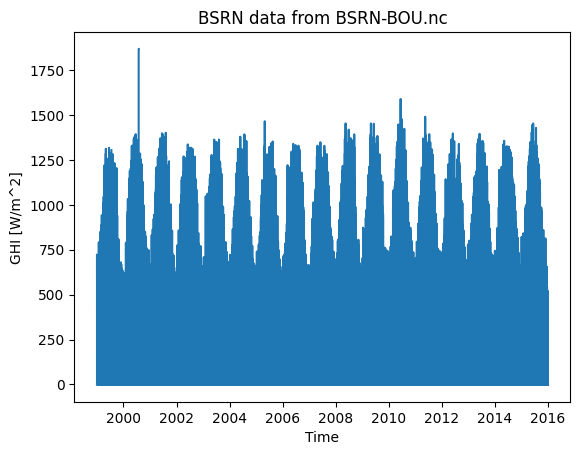

In [148]:
# Load the data
i_path = 2
ds = xr.open_dataset(paths[i_path])
ds = ds.sel(time=slice(times_begin[i_path], times_end[i_path]))

# Plot the data
fig, ax = plt.subplots()
ds["GHI"].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN data from " + paths[i_path])
plt.show()

# Interpolate the missing values using mean
mean = ds["GHI"].mean(dim="time")
ds_without_nans = ds["GHI"].fillna(mean)

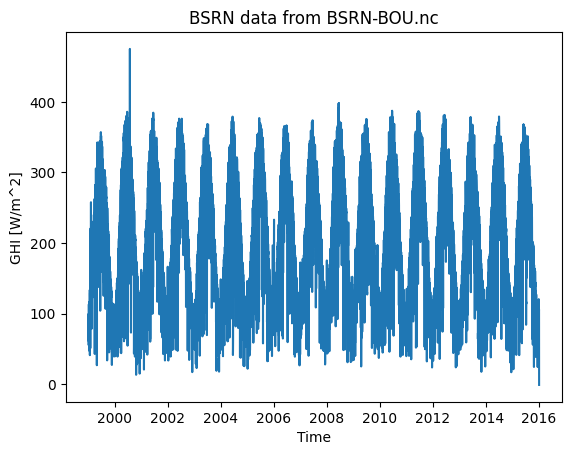

In [173]:
# Calculate the dataframe resampled with the second resampling rate
ds_resampled = ds_without_nans.resample(time="24H").mean()
# Plot the data
fig, ax = plt.subplots()
ds_resampled.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN data from " + paths[i_path])
plt.show()

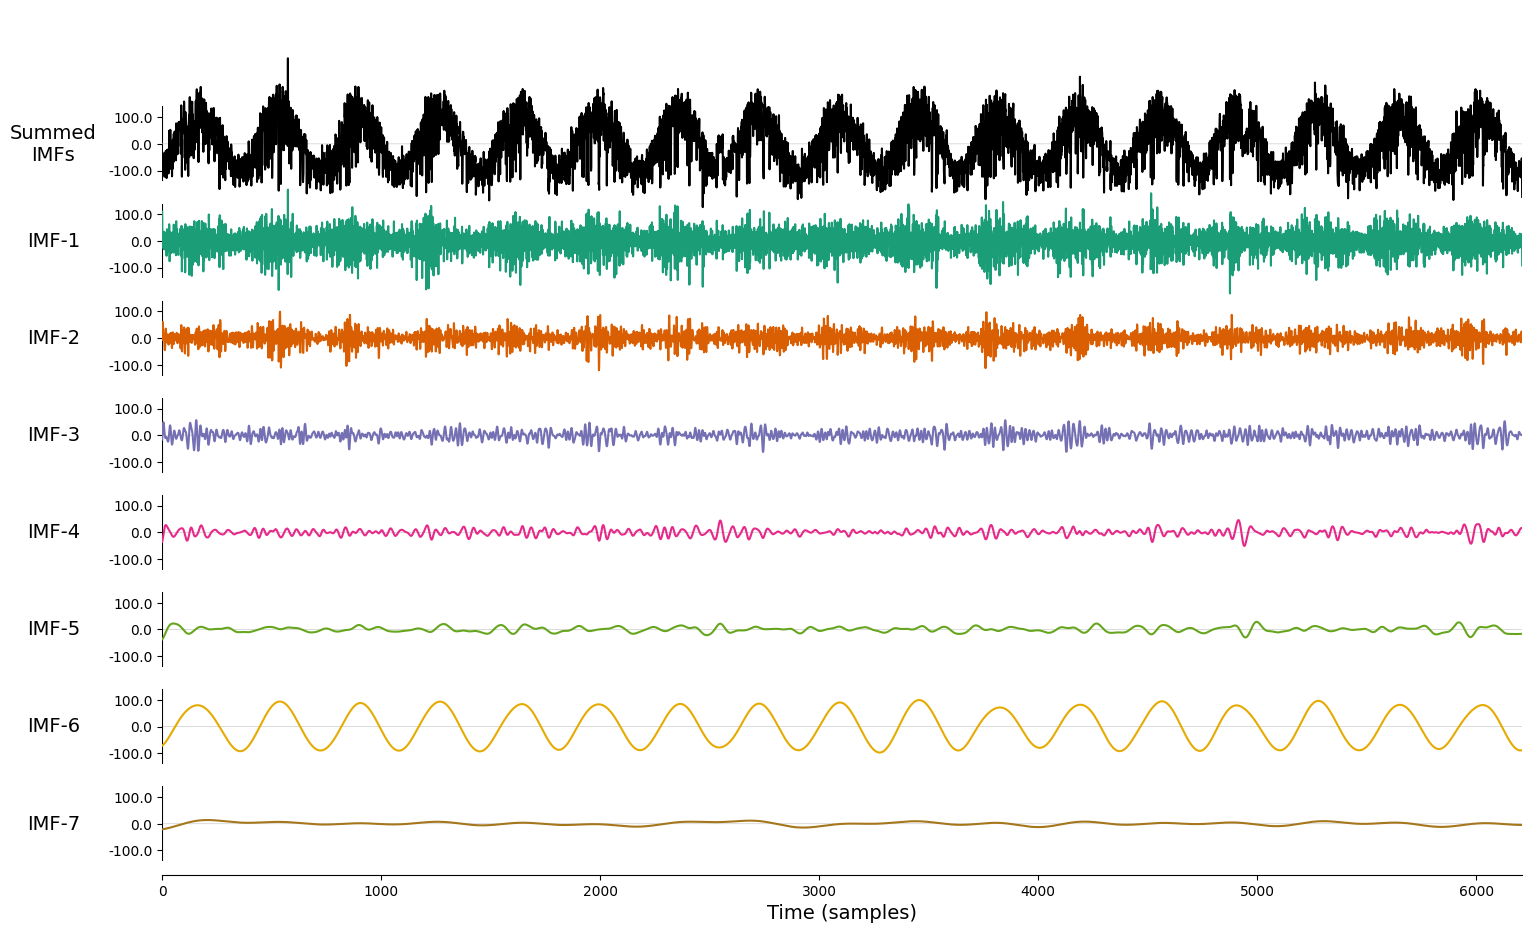

In [174]:
import emd

# Calculate the EMD
imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=256, nprocesses=32, ensemble_noise=4)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')

c:\Users\Marius\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 100000 is greater than input length  = 6210, using nperseg = 6210
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Marius\AppData\Local\Temp\ipykernel_9968\685190708.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
C:\Users\Marius\AppData\Local\Temp\ipykernel_9968\685190708.py:17: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


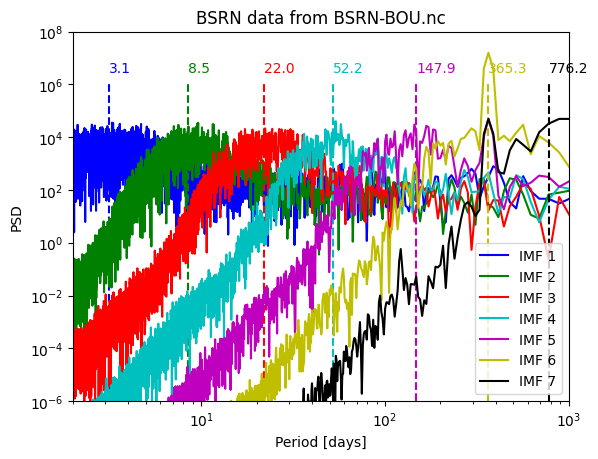

In [175]:
# Compute PSDs of the IMFs
from scipy import signal
from itertools import cycle

f, Pxx = signal.welch(imf.T, fs=1, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_title("BSRN data from " + paths[i_path])
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
ax.set_xlim(2, 1000)
plt.show()

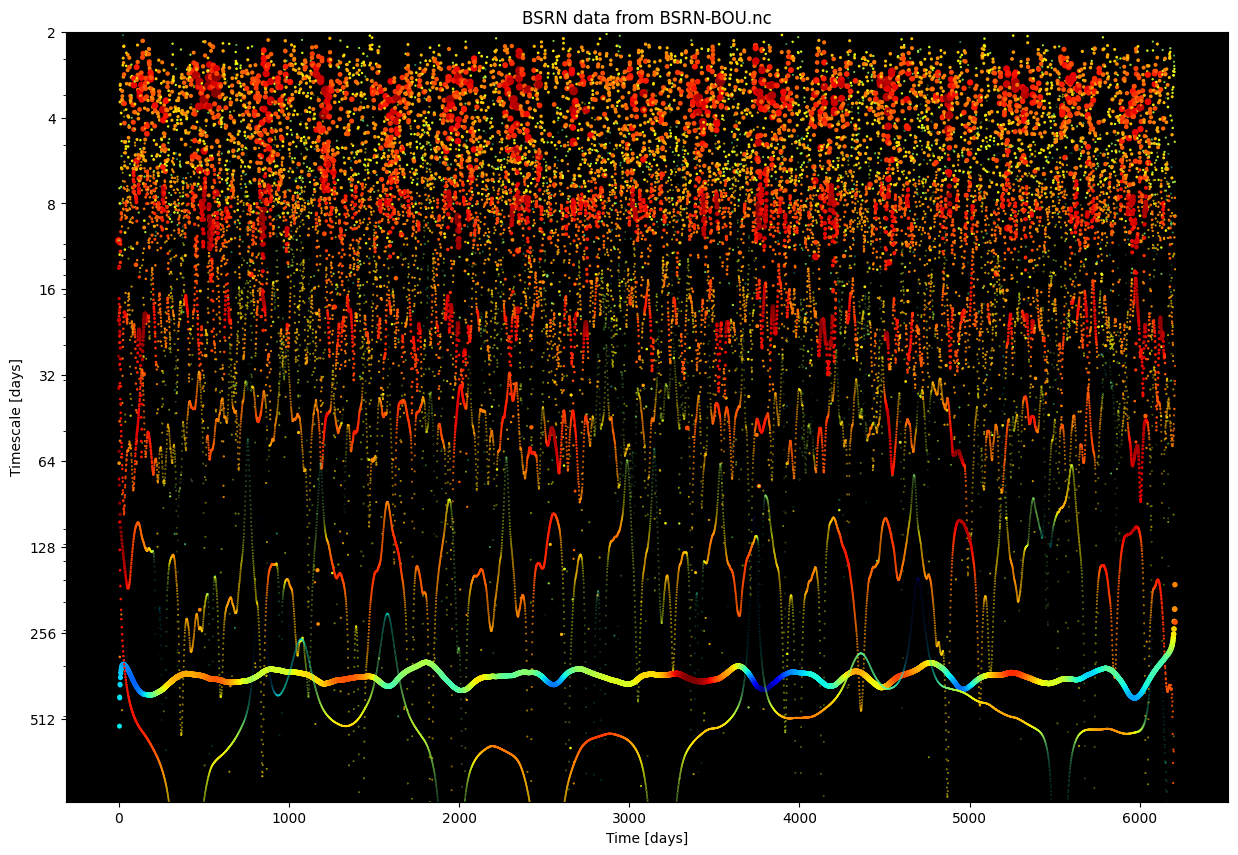

In [176]:
plt.figure(figsize=(15, 10))
# Set background color
plt.rcParams['axes.facecolor'] = "k"
for i in range(imf.shape[1]):
    plt.scatter(np.arange(len(imf)), IF[:, i], c=np.log(IA[:, i]), cmap="jet", s=0.001*IA[:, i]**2, label="IMF %d" % (i +1))
plt.xlabel("Time [days]")
plt.ylabel("Timescale [days]")
plt.title("BSRN data from " + paths[i_path])
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.show()

plt.rcParams['axes.facecolor'] = "w"


In [177]:
# Compute hilbert huang transform
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=False)

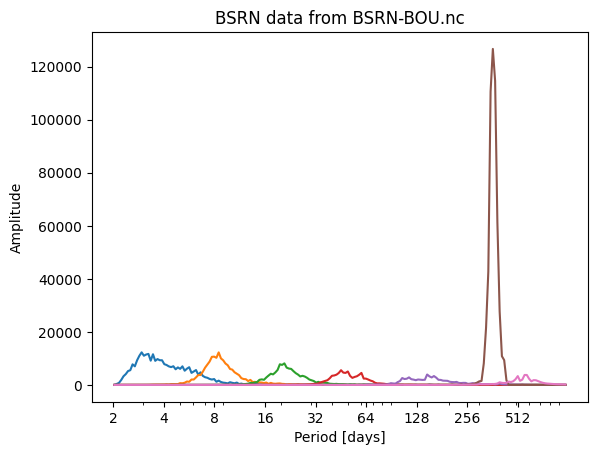

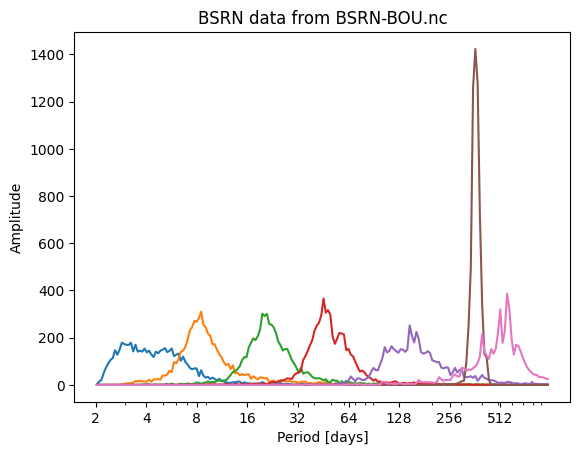

In [178]:
f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
f, hht_0a = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)

# Plot the HHT
for i in range(hht.shape[1]):
    plt.plot(1 / freq_centres, hht[:, i], label="IMF %d" % (i +1))
plt.xlabel("Period [days]")
plt.ylabel("Amplitude")
plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.show()


# Plot the HHT
for i in range(hht.shape[1]):
    plt.plot(1 / freq_centres, hht_0a[:, i], label="IMF %d" % (i +1))
plt.xlabel("Period [days]")
plt.ylabel("Amplitude")
plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.show()

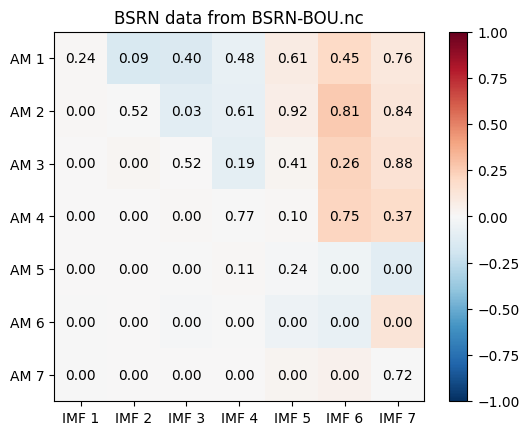

In [179]:
# Compute Kendall's taucorrelation matrix between IA and IMFs
from scipy.stats import kendalltau

taus = np.zeros((imf.shape[1], imf.shape[1]))
ps = np.zeros((imf.shape[1], imf.shape[1]))
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        tau, p = kendalltau(IA[:, i], imf[:, j])
        taus[i, j] = tau
        ps[i, j] = p

# Plot the correlation matrix as a heatmap (p values are written in the cells)
plt.imshow(taus, cmap="RdBu_r", vmin=-1, vmax=1)
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        plt.text(i, j, "%.2f" % ps[i, j], ha="center", va="center")
plt.xticks(np.arange(imf.shape[1]), ["IMF %d" % (i + 1) for i in range(imf.shape[1])])
plt.yticks(np.arange(imf.shape[1]), ["AM %d" % (i + 1) for i in range(imf.shape[1])])
plt.colorbar()
plt.title("BSRN data from " + paths[i_path])
plt.show()

In [166]:
resample_rates = np.arange(24, 48, 1)
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
SWMFs = np.zeros((len(resample_rates), 7))
for i_rr, rr in enumerate(resample_rates):
    freq_ratio = 24 / rr
    ds_resampled = ds_without_nans.resample(time="{}H".format(rr)).mean()
    print(len(ds_resampled))
    imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=256, nprocesses=32, ensemble_noise=4)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
    SWMFs[i_rr, :] = freq_ratio * np.sum(hht * f[:, None], axis=0) / np.sum(hht, axis=0)

6210
5961
5732
5520
5323
5139
4968
4807
4657
4516
4383
4258
4140
4028
3922
3821
3726
3635
3549
3466
3387
3312
3240
3171


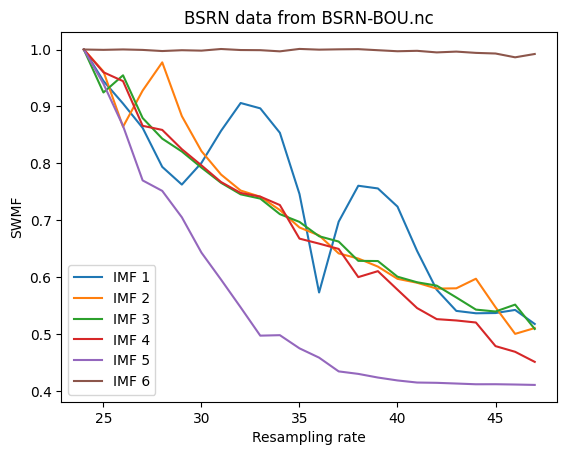

In [168]:
# Plot the SWMFs
for i in range(imf.shape[1]-1):
    plt.plot(resample_rates, SWMFs[:, i] / SWMFs[0, i], label="IMF %d" % (i +1))
plt.xlabel("Resampling rate")
plt.ylabel("SWMF")
plt.title("BSRN data from " + paths[i_path])
plt.legend()
plt.show()